In [1]:
import mplfinance as mpf
import pymssql
import pandas as pd
import numpy as np

db_settings = {
    "host": "172.30.52.193",
    "port": 1433,
    "user": "sa",
    "password": "255089",
    "database": "ncudb",
    "charset": "utf8"
}

In [2]:
price = []
buy_or_sell = []

try:  
    conn = pymssql.connect(**db_settings)
    with conn.cursor() as cursor:
        command = " SELECT [date], o, h, l, c, v\
                    FROM stock_price \
                    WHERE stock_code = '2330' \
                    ORDER BY [date] ASC;"
        cursor.execute(command)
        price = cursor.fetchall()
        command = " EXEC [dbo].[GB_aggregation] '2330'"
        cursor.execute(command)
        buy_or_sell = cursor.fetchall()
except Exception as ex:
    print(ex)

conn.close()

In [3]:
price_array = []
for r in price:
    r = list(r)
    r[0] = r[0];
    r[1] = float(r[1])
    r[2] = float(r[2])
    r[3] = float(r[3])
    r[4] = float(r[4])
    r[5] = float(r[5])
    price_array.append(r)

In [4]:
price_df = pd.DataFrame(price_array)
price_df.index = pd.to_datetime(price_df[0])
price_df = price_df.drop(columns=[0])
price_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
price_df.index.name = 'Date'
price_df

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,530.0,540.0,528.0,536.0,33316.0
2021-01-05,536.0,542.0,535.0,542.0,28512.0
2021-01-06,555.0,555.0,541.0,549.0,55462.0
2021-01-07,554.0,570.0,553.0,565.0,47905.0
2021-01-08,580.0,580.0,571.0,580.0,56426.0
...,...,...,...,...,...
2023-03-13,513.0,518.0,509.0,516.0,24150.0
2023-03-14,511.0,514.0,510.0,510.0,24848.0
2023-03-15,515.0,516.0,510.0,511.0,21075.0


In [5]:
buy_sell_array = []
for r in buy_or_sell:
    r = list(r)
    r[0] = r[0];
    r[1] = float(r[1])
    r[2] = int(r[2])
    r[3] = float(r[3])
    r[4] = int(r[4])
    buy_sell_array.append(r)

In [6]:
bs_df = pd.DataFrame(buy_sell_array)
bs_df.index = pd.to_datetime(bs_df[0])
bs_df = bs_df.drop(columns=[0])
bs_df.sort_index(inplace=True)
bs_df.columns = ['Price', 'Buy_or_Sell', 'Asset', 'Stock_Amount']
bs_df.index.name = 'Date'
bs_df=bs_df.drop(columns=['Price'])
bs_df

,Buy_or_Sell,Asset,Stock_Amount
Date,,,
2021-01-15,-1,0.0,0
2021-01-22,-1,0.0,0
2021-02-01,1,-1833.0,3
2021-02-02,1,-3097.0,5
2021-02-25,1,-3732.0,6
...,...,...,...
2023-01-12,1,-9925.0,20
2023-01-31,-1,-8359.0,17
2023-02-06,-1,-7307.0,15


In [15]:
total_df = pd.merge(price_df, bs_df, how='left', on='Date')

total_df['Buy_or_Sell'] = total_df['Buy_or_Sell'].fillna(0)
total_df['Asset'] = total_df['Asset'].fillna(method='ffill')
total_df['Asset'] = total_df['Asset'].fillna(0)
total_df['Stock_Amount'] = total_df['Stock_Amount'].fillna(method='ffill')
total_df['Stock_Amount'] = total_df['Stock_Amount'].fillna(0)

total_df['total'] = total_df['Close'] * total_df['Stock_Amount'] + total_df['Asset']

total_df

,Open,High,Low,Close,Volume,Buy_or_Sell,Asset,Stock_Amount,total
Date,,,,,,,,,
2021-01-04,530.0,540.0,528.0,536.0,33316.0,0.0,0.0,0.0,0.0
2021-01-05,536.0,542.0,535.0,542.0,28512.0,0.0,0.0,0.0,0.0
2021-01-06,555.0,555.0,541.0,549.0,55462.0,0.0,0.0,0.0,0.0
2021-01-07,554.0,570.0,553.0,565.0,47905.0,0.0,0.0,0.0,0.0
2021-01-08,580.0,580.0,571.0,580.0,56426.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-03-13,513.0,518.0,509.0,516.0,24150.0,0.0,-6266.0,13.0,442.0
2023-03-14,511.0,514.0,510.0,510.0,24848.0,0.0,-6266.0,13.0,364.0
2023-03-15,515.0,516.0,510.0,511.0,21075.0,0.0,-6266.0,13.0,377.0


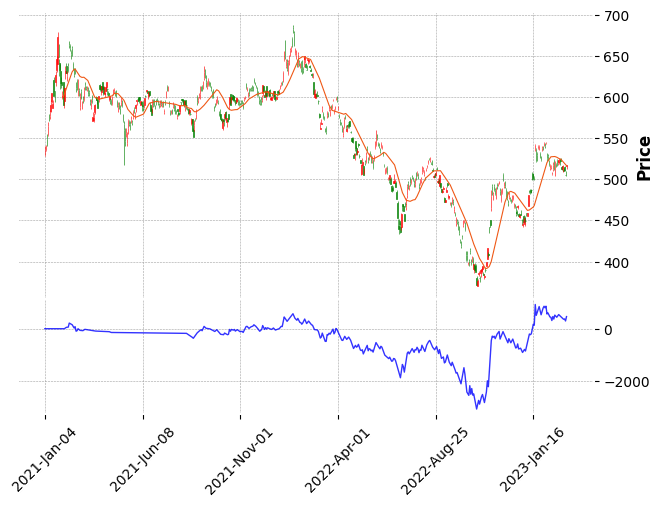

In [20]:
mc = mpf.make_marketcolors(up='r',
                           down='g',
                           edge='',
                           wick='inherit',
                           volume='inherit')
s = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=mc)
earn_plot = mpf.make_addplot(total_df['total'], type='line', color='b', width=1, alpha=0.8, panel=1)
mpf.plot(total_df, addplot=earn_plot,type='candle', style=s, mav=(20))